In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\miiki\Desktop\DATA_SCIENCE\APRENDIZAJE_PYTHON\venvs\Nuclio\env_nuclio\Lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 1.5.1
XGBoost version 1.3.3


In [3]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [4]:
df= pd.read_csv((TRAIN_CSV_PATH),index_col=0)

In [5]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


**Objetivo: En base a los meses que disponemos en el dataset, sacar la predicción de 'monthly_sale' del mes que viene.**

In [6]:
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  13262 non-null  float64       
 7   monthly_sales          13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [8]:
# conocer fechas unicas. 33 para entrenar 1 para predecir
df['date'].nunique()

34

In [9]:
# Series temproales únicas
df['unique_id'].nunique()

426

In [10]:
df.describe()

,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
count,14484.000000,14484.000000,14484.000000,14484.000000,13262.000000,13756.000000
mean,10.833333,31.967136,39.356808,8626.431925,916.089314,7.337889
std,6.227364,15.236351,20.439654,5905.273346,820.945949,7.915032
min,0.000000,3.000000,2.000000,32.000000,4.928571,0.000000
25%,7.000000,22.000000,30.000000,4248.000000,299.000000,2.000000
50%,7.000000,31.000000,35.000000,6457.000000,649.000000,5.000000
75%,16.000000,44.000000,55.000000,12551.000000,1149.000000,9.000000
max,23.000000,59.000000,83.000000,22088.000000,9305.121212,30.000000


In [11]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

Df de ventas, un caso transaccional. En este caso yo puedo identificar nulos de 2 formas. 
- 1. Si isnull()
- 2. Si el 'monthly_sales' = 0

<Axes: >

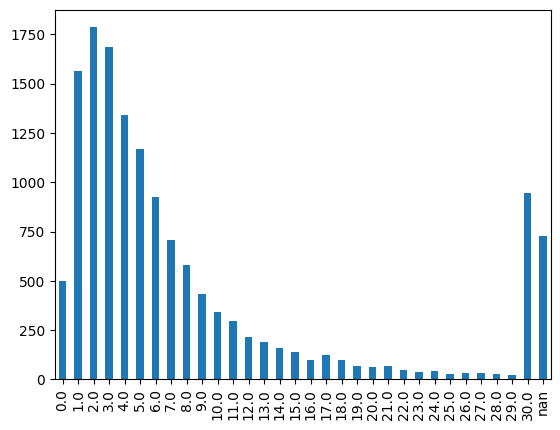

In [12]:
(
    df
    ['monthly_sales']
    .value_counts(dropna= False)
    .sort_index()
    .plot(kind='bar')

)

In [13]:
import seaborn as sns
import numpy as np

In [14]:
pt= (
    df
    .pivot_table(
        index= 'date',
        columns= 'unique_id',
        values= 'monthly_sales',
        aggfunc='sum'
    
    )
    .replace(
        {
            0:np.nan
        }
    
    )
#     .isnull()
    .notnull()
)

<Axes: xlabel='unique_id', ylabel='date'>

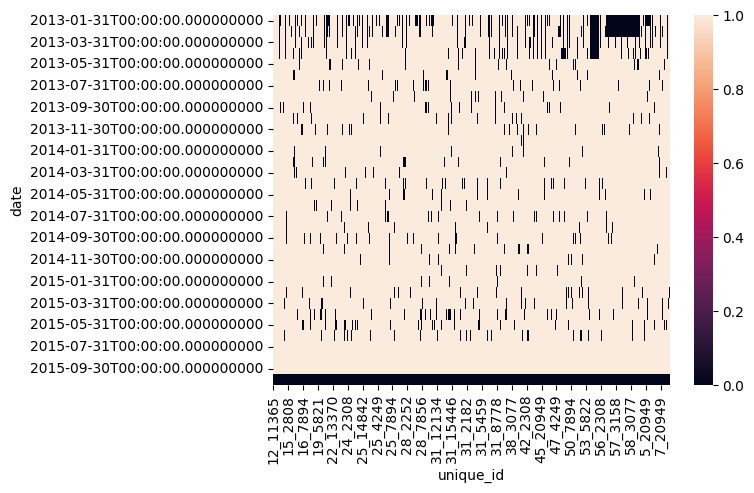

In [15]:
sns.heatmap(pt)

**Importante esto:** comprobar si mis series temporales estan completas (todos productos y todas las fechas, están todas las combinaciones) 

**Por eso chequeo fundamental:**

In [16]:
df.shape

(14484, 8)

In [17]:
df['unique_id'].nunique()

426

In [18]:
df['date'].nunique()

34

In [19]:
426 * 34

14484

De partida están todos los registros posible. (14484)

Aquí tenemos nuestro primer EDA, minicontacto con el dataset. **Pero mi objetivo inicial** es tener un codigo que yo pueda correr de principio a fin, 1 lines(importo dataset), última (predicción)

Veamos cuales son las fechas min y max de nuestro dataset:

In [20]:
MIN_DATE= df['date'].min()
MAX_DATE= df['date'].max()

In [21]:
print (f'Min date is {MIN_DATE}\nMax date is {MAX_DATE}')

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [22]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

## Preprocessing

In [23]:
sample_ts= '31_4249'

In [24]:
df[df['unique_id']==sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [25]:
df.fillna({
    'monthly_sales':0
}, inplace= True)

In [26]:
df['monthly_average_price']=(
    df.groupby('unique_id',group_keys=False)
    ['monthly_average_price'].apply(
        lambda series: series.interpolate().ffill().bfill()
    )
)

# df['monthly_average_price']=(
#     df.groupby('unique_id',group_keys=False)
#     ['monthly_average_price'].apply(
#         lambda series: series.bfill().ffill()
#     )
# )

In [27]:
df.sort_values(['unique_id','date'], ascending= True, inplace= True)

In [28]:
df[df['unique_id']==sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [30]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [31]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


## **EDA:** 
Vamos al notebook de EDA para ver como son nuestras series temporales y coger ideas para futuras variables 

### Build Time Series Features (**CORE IDEA**)

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ganancias totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [32]:
df['revenue']=df['monthly_average_price']*df['monthly_sales']

In [33]:
def build_ts_vars(df,gb_list,target_column,agg_func,agg_func_name,nr_lags):
    assert 'date' in df.columns.tolist(), 'Date must be in df columns'

    new_name= '_'.join(gb_list + [target_column] + [agg_func_name])
    
    gb_df_= (
        df
        .set_index('date')
        .groupby(gb_list)
        .resample('M')[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name}
        )
    )

    for lag in range(nr_lags):
        gb_df_[f'{new_name}_lag{lag+1}'] = (
            gb_df_
            .groupby(gb_list)[new_name]
            .transform(
                lambda series:series.shift(lag+1)
            )
        )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_


    

In [34]:
vars_item_id= build_ts_vars(
    df = df,
    gb_list = ['item_id'],
    target_column = 'monthly_sales',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)

vars_shop_item_revenue= build_ts_vars(
    df = df,
    gb_list = ['shop_id','item_id'],
    target_column = 'revenue',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)

vars_shop_id_revenue= build_ts_vars(
    df = df,
    gb_list = ['shop_id'],
    target_column = 'revenue',
    agg_func = np.sum,
    agg_func_name = 'sum',
    nr_lags = 2

)


# vars_item_id = build_ts_vars(
#     df = df,
#     gb_list = ["item_id"],
#     target_column = "monthly_sales",
#     agg_func = np.sum,
#     agg_func_name =  "sum",
#     nr_lags = 3
    
# )

# vars_shop_item_revenue = build_ts_vars(
#     df = df,
#     gb_list = ["shop_id", "item_id"],
#     target_column = "revenue",
#     agg_func = np.sum,
#     agg_func_name =  "sum",
#     nr_lags = 3
    
# )

Dropping columns that might cause target leakage item_id_monthly_sales_sum
Dropping columns that might cause target leakage shop_id_item_id_revenue_sum
Dropping columns that might cause target leakage shop_id_revenue_sum


In [35]:
# vars_shop_id_revenue
vars_shop_item_revenue


,shop_id,item_id,date,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2
0,3,5822,2013-01-31,NaN,NaN
1,3,5822,2013-02-28,999.0,NaN
2,3,5822,2013-03-31,999.0,999.0
3,3,5822,2013-04-30,1049.0,999.0
4,3,5822,2013-05-31,1048.5,1049.0
...,...,...,...,...,...
14479,59,22088,2015-06-30,357.0,357.0
14480,59,22088,2015-07-31,476.0,357.0
14481,59,22088,2015-08-31,833.0,476.0
14482,59,22088,2015-09-30,833.0,833.0


### Join TS Features

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano

In [36]:
print(df.shape)

df = pd.merge(df, vars_item_id, on = ['date', 'item_id'], how = "left")
df = pd.merge(df, vars_shop_item_revenue, on = ['date', 'shop_id', 'item_id'], how = "left")
df = pd.merge(df, vars_shop_id_revenue, on = ['date', 'shop_id'], how = 'left')

print(df.shape)

# print(df.shape)

# df = pd.merge(df, vars_item_id, on = ["date", "item_id"], how = "left")
# df = pd.merge(df, vars_shop_item_revenue, on = ["date", "shop_id", "item_id"], how = "left")

# print(df.shape)

(14484, 9)
(14484, 15)


# ENTRENAMOS SIEMPRE CON EL PASADO

In [37]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,30.0,NaN,45345.378788,NaN,213263.540693,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,27.0,30.0,41394.375000,45345.378788,236417.673786,213263.540693
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,30.0,27.0,97574.107143,41394.375000,271836.568071,236417.673786
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,27.0,30.0,42943.909091,97574.107143,231494.439542,271836.568071


### Train Test Split

In [38]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'revenue',
 'item_id_monthly_sales_sum_lag1',
 'item_id_monthly_sales_sum_lag2',
 'shop_id_item_id_revenue_sum_lag1',
 'shop_id_item_id_revenue_sum_lag2',
 'shop_id_revenue_sum_lag1',
 'shop_id_revenue_sum_lag2']

In [39]:
COLUMNS_TO_DROP = [
    'revenue',
    'monthly_sales',
    'date'
]

In [40]:
df.set_index("unique_id", inplace = True)

In [41]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2
unique_id,,,,,,,,,,,,,,
18_17717,2015-05-31,5,18,79,17717,841.538462,16.0,13464.615385,259.0,313.0,18972.0,26151.025641,70634.000000,96649.263736
24_6457,2014-12-31,7,24,30,6457,699.000000,1.0,699.000000,18.0,25.0,1398.0,1398.000000,107025.000000,90076.000000
31_2607,2013-11-30,7,31,55,2607,299.000000,4.0,1196.000000,4.0,0.0,1196.0,0.000000,372941.015492,383443.543870
19_7894,2013-12-31,6,19,6,7894,1490.000000,5.0,7450.000000,143.0,233.0,11920.0,11920.000000,61489.000000,67259.300000
38_5821,2013-02-28,10,38,35,5821,599.000000,0.0,0.000000,19.0,NaN,0.0,NaN,38655.895833,NaN


In [42]:
train_index = sorted(list(df['date'].unique()))[:-2] # todos meses menos 2 últimos

valid_index = [sorted(list(df['date'].unique()))[-2]] # últimos 2 meses

test_index = [sorted(list(df['date'].unique()))[-1]] # último mes 

In [43]:
train_index

[numpy.datetime64('2013-01-31T00:00:00.000000000'),
 numpy.datetime64('2013-02-28T00:00:00.000000000'),
 numpy.datetime64('2013-03-31T00:00:00.000000000'),
 numpy.datetime64('2013-04-30T00:00:00.000000000'),
 numpy.datetime64('2013-05-31T00:00:00.000000000'),
 numpy.datetime64('2013-06-30T00:00:00.000000000'),
 numpy.datetime64('2013-07-31T00:00:00.000000000'),
 numpy.datetime64('2013-08-31T00:00:00.000000000'),
 numpy.datetime64('2013-09-30T00:00:00.000000000'),
 numpy.datetime64('2013-10-31T00:00:00.000000000'),
 numpy.datetime64('2013-11-30T00:00:00.000000000'),
 numpy.datetime64('2013-12-31T00:00:00.000000000'),
 numpy.datetime64('2014-01-31T00:00:00.000000000'),
 numpy.datetime64('2014-02-28T00:00:00.000000000'),
 numpy.datetime64('2014-03-31T00:00:00.000000000'),
 numpy.datetime64('2014-04-30T00:00:00.000000000'),
 numpy.datetime64('2014-05-31T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-31T00:00:00.000000000'),
 numpy.datet

In [44]:
X_train = (
    df[
    df['date']
    .isin(train_index)
    ]
    .drop(COLUMNS_TO_DROP, axis= 1)
)
Y_train = (
    df[
    df['date']
    .isin(train_index)
    ]
    ['monthly_sales']
)


X_valid = (
    df[
    df['date']
    .isin(valid_index)
    ]
    .drop(COLUMNS_TO_DROP, axis= 1)
)
Y_valid = (
    df[
    df['date']
    .isin(valid_index)
    ]
    ['monthly_sales']
)


X_test = (
    df[
    df['date']
    .isin(test_index)
    ]
    .drop(COLUMNS_TO_DROP, axis= 1)
)
Y_test = (
    df[
    df['date']
    .isin(test_index)
    ]
    ['monthly_sales']
)

In [45]:
X_train.head()

,city_id,shop_id,item_category_id,item_id,monthly_average_price,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2
unique_id,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,30.0,NaN,45345.378788,NaN,213263.540693,NaN
12_11365,16,12,9,11365,3252.470238,27.0,30.0,41394.375000,45345.378788,236417.673786,213263.540693
12_11365,16,12,9,11365,1590.515152,30.0,27.0,97574.107143,41394.375000,271836.568071,236417.673786
12_11365,16,12,9,11365,1447.531250,27.0,30.0,42943.909091,97574.107143,231494.439542,271836.568071


In [46]:
Y_train.head()

unique_id
12_11365    30.0
12_11365    27.0
12_11365    30.0
12_11365    27.0
12_11365    30.0
Name: monthly_sales, dtype: float64

In [47]:
X_valid.head()

,city_id,shop_id,item_category_id,item_id,monthly_average_price,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_revenue_sum_lag1,shop_id_revenue_sum_lag2
unique_id,,,,,,,,,,,
12_11365,16,12,9,11365,995.680556,13.0,6.0,24312.785714,6835.000000,110960.301701,69015.967269
12_11369,16,12,9,11369,1321.367605,21.0,30.0,21881.300000,24322.876190,110960.301701,69015.967269
12_11370,16,12,9,11370,681.715341,30.0,30.0,22540.892857,12313.213287,110960.301701,69015.967269
12_11373,16,12,9,11373,437.929115,30.0,30.0,15125.323129,8694.877792,110960.301701,69015.967269
12_12231,16,12,49,12231,350.000000,2.0,1.0,700.000000,350.000000,110960.301701,69015.967269


In [48]:
Y_valid.head()

unique_id
12_11365    21.0
12_11369    30.0
12_11370    30.0
12_11373    30.0
12_12231     2.0
Name: monthly_sales, dtype: float64

In [49]:
print(X_train.shape, X_valid.shape)
print(X_train.columns)
print(Y_train.describe(), Y_valid.describe())

(13632, 11) (426, 11)
Index(['city_id', 'shop_id', 'item_category_id', 'item_id',
       'monthly_average_price', 'item_id_monthly_sales_sum_lag1',
       'item_id_monthly_sales_sum_lag2', 'shop_id_item_id_revenue_sum_lag1',
       'shop_id_item_id_revenue_sum_lag2', 'shop_id_revenue_sum_lag1',
       'shop_id_revenue_sum_lag2'],
      dtype='object')
count    13632.000000
mean         7.226086
std          7.912928
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         30.000000
Name: monthly_sales, dtype: float64 count    426.000000
mean       5.713615
std        7.386643
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       30.000000
Name: monthly_sales, dtype: float64


### Model Train

In [50]:
# max_depth
# n_estimators
# early_stopping_rounds

model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175)

model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valid, Y_valid)],
    verbose = True
)

[0]	validation_0-rmse:7.99672	validation_1-rmse:6.66700
[1]	validation_0-rmse:6.44019	validation_1-rmse:5.18065
[2]	validation_0-rmse:5.46992	validation_1-rmse:4.30489
[3]	validation_0-rmse:4.90619	validation_1-rmse:3.80985
[4]	validation_0-rmse:4.56793	validation_1-rmse:3.53562
[5]	validation_0-rmse:4.35586	validation_1-rmse:3.36705
[6]	validation_0-rmse:4.19777	validation_1-rmse:3.26311
[7]	validation_0-rmse:4.11761	validation_1-rmse:3.21039
[8]	validation_0-rmse:3.99664	validation_1-rmse:3.16876
[9]	validation_0-rmse:3.93886	validation_1-rmse:3.15254
[10]	validation_0-rmse:3.89130	validation_1-rmse:3.13545
[11]	validation_0-rmse:3.85633	validation_1-rmse:3.12484
[12]	validation_0-rmse:3.82143	validation_1-rmse:3.12895
[13]	validation_0-rmse:3.79733	validation_1-rmse:3.12467
[14]	validation_0-rmse:3.75593	validation_1-rmse:3.12239
[15]	validation_0-rmse:3.73159	validation_1-rmse:3.11183
[16]	validation_0-rmse:3.70777	validation_1-rmse:3.11071
[17]	validation_0-rmse:3.67642	validation

C:\Users\miiki\Desktop\DATA_SCIENCE\APRENDIZAJE_PYTHON\venvs\Nuclio\env_nuclio\Lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[38]	validation_0-rmse:3.33110	validation_1-rmse:3.08459
[39]	validation_0-rmse:3.31186	validation_1-rmse:3.08332
[40]	validation_0-rmse:3.30304	validation_1-rmse:3.06793
[41]	validation_0-rmse:3.29777	validation_1-rmse:3.06832
[42]	validation_0-rmse:3.29092	validation_1-rmse:3.06833
[43]	validation_0-rmse:3.28122	validation_1-rmse:3.07142
[44]	validation_0-rmse:3.27271	validation_1-rmse:3.07524
[45]	validation_0-rmse:3.26118	validation_1-rmse:3.07890
[46]	validation_0-rmse:3.23606	validation_1-rmse:3.06724
[47]	validation_0-rmse:3.21536	validation_1-rmse:3.07025
[48]	validation_0-rmse:3.20873	validation_1-rmse:3.07441
[49]	validation_0-rmse:3.19854	validation_1-rmse:3.06808
[50]	validation_0-rmse:3.19325	validation_1-rmse:3.06738
[51]	validation_0-rmse:3.18659	validation_1-rmse:3.06553
[52]	validation_0-rmse:3.17348	validation_1-rmse:3.06785
[53]	validation_0-rmse:3.15976	validation_1-rmse:3.06410
[54]	validation_0-rmse:3.14738	validation_1-rmse:3.06524
[55]	validation_0-rmse:3.13195	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=18,
             num_parallel_tree=1, random_state=175, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=175, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Model Evaluation (**CORE IDEA**)

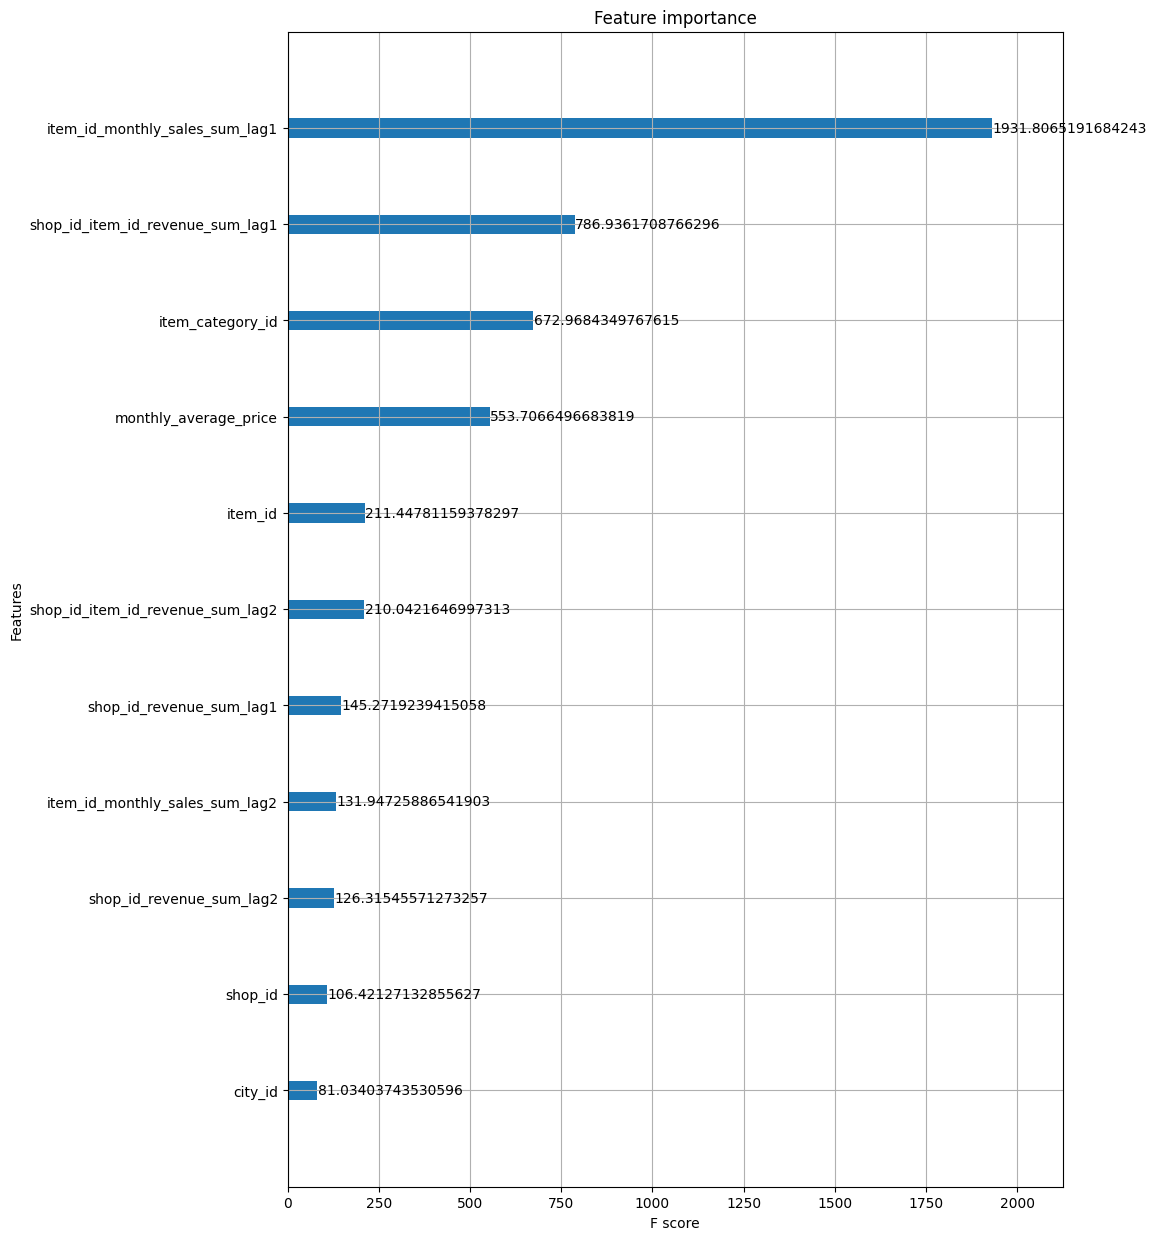

In [51]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

### Prediction

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [52]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

C:\Users\miiki\Desktop\DATA_SCIENCE\APRENDIZAJE_PYTHON\venvs\Nuclio\env_nuclio\Lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [53]:
X_test.reset_index(inplace = True)

In [54]:
Y_train_predict = model.predict(X_train)
Y_valid_predict = model.predict(X_valid)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valid = np.sqrt(
    mean_squared_error(
        y_true = Y_valid,
        y_pred = Y_valid_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valid = str(round(rmse_valid, 3)).replace(".", "_")

C:\Users\miiki\Desktop\DATA_SCIENCE\APRENDIZAJE_PYTHON\venvs\Nuclio\env_nuclio\Lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [55]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valid}")

Train RMSE: 2_75
Validation RMSE: 3_042


In [56]:
# Obtener fecha y hora actuales en formato deseado
timestamp = datetime.now().strftime("%m-%d_%H-%M")

(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"subm{timestamp}_train_{rmse_train}_valida_{rmse_valid}.csv", index = False)
)